In [26]:
!nvidia-smi

Tue Apr  1 04:36:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
from pathlib import Path
import torch
from torchvision.io import read_image, write_png
from torch.utils.cpp_extension import load_inline


def compile_extension():
    cuda_source = Path("rgb_to_greyscale.cu").read_text()
    cpp_source = "torch::Tensor rgb_to_grayscale(torch::Tensor image);"

    # Load the CUDA kernel as a PyTorch extension
    rgb_to_grayscale_extension = load_inline(
        name="rgb_to_grayscale_extension",
        cpp_sources=cpp_source,
        cuda_sources=cuda_source,
        functions=["rgb_to_grayscale"],
        with_cuda=True,
        extra_cuda_cflags=["-O2"],
        verbose=True
        # build_directory='./cuda_build',
    )
    return rgb_to_grayscale_extension


def _main():
    """
    Use torch cpp inline extension function to compile the kernel in grayscale_kernel.cu.
    Read input image, convert it to grayscale via custom cuda kernel and write it out as png.
    """
    ext = compile_extension()

    x = read_image("test.png").permute(1, 2, 0).cuda()
    print("mean:", x.float().mean())
    print("Input image:", x.shape, x.dtype)

    assert x.dtype == torch.uint8

    y = ext.rgb_to_grayscale(x)

    print("Output image:", y.shape, y.dtype)
    print("mean", y.float().mean())
    write_png(y.permute(2, 0, 1).cpu(), "output.png")



In [21]:
_main()

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/rgb_to_grayscale_extension...
The input conditions for extension module rgb_to_grayscale_extension have changed. Bumping to version 1 and re-building as rgb_to_grayscale_extension_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/rgb_to_grayscale_extension/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module rgb_to_grayscale_extension_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module rgb_to_grayscale_extension_v1...


mean: tensor(117.7304, device='cuda:0')
Input image: torch.Size([1024, 1536, 3]) torch.uint8
Output image: torch.Size([1024, 1536, 1]) torch.uint8
mean tensor(119.9218, device='cuda:0')


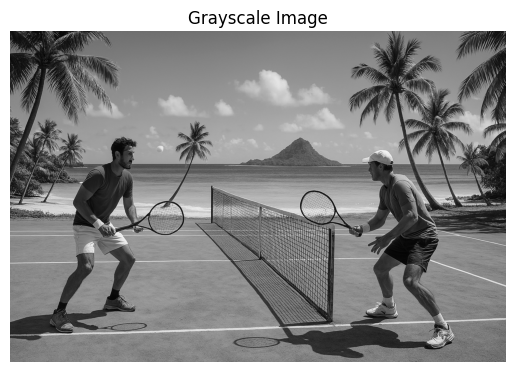

In [100]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

img = read_image("output.png")  # [1, H, W], dtype=uint8
plt.imshow(img.squeeze(0).cpu(), cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

In [65]:
!rm -rf /root/.cache/torch_extensions
!pip install ninja --quiet


## Sobel Filter for Edge Detection

In [92]:
from pathlib import Path
import torch
from torchvision.io import read_image, write_png
from torch.utils.cpp_extension import load_inline


def compile_extension():
    cuda_source = Path("sobel.cu").read_text()
    cpp_source = "torch::Tensor sobel_edge(torch::Tensor image);"

    # Load the CUDA kernel as a PyTorch extension
    sobel_extension = load_inline(
        name="sobel_extension",
        cpp_sources=cpp_source,
        cuda_sources=cuda_source,
        functions=["sobel_edge"],
        with_cuda=True,
        extra_cuda_cflags=["-O2"],
        verbose=True
        # build_directory='./cuda_build',
    )
    return sobel_extension


def _main():
    """
    Use torch cpp inline extension function to compile the kernel in grayscale_kernel.cu.
    Read input image, convert it to grayscale via custom cuda kernel and write it out as png.
    """
    ext = compile_extension()

    x = read_image("output.png").squeeze(0).cuda()
    print("mean:", x.float().mean())
    print("Input image:", x.shape, x.dtype)

    assert x.dtype == torch.uint8

    y = ext.sobel_edge(x)

    print("Output image:", y.shape, y.dtype)
    print("mean", y.float().mean())
    write_png(y.unsqueeze(0).cpu(), "output_sobel.png")

In [93]:
_main()

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module sobel_extension, skipping build step...
Loading extension module sobel_extension...


mean: tensor(119.9218, device='cuda:0')
Input image: torch.Size([1024, 1536]) torch.uint8
Output image: torch.Size([1024, 1536]) torch.uint8
mean tensor(81.3101, device='cuda:0')


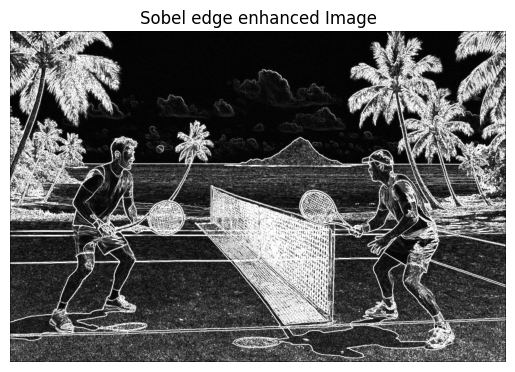

In [99]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

img = read_image("output_sobel.png")  # [1, H, W], dtype=uint8
plt.imshow(img.squeeze(0).cpu(), cmap='gray')
plt.title("Sobel edge enhanced Image")
plt.axis('off')
plt.show()

torch.Size([1, 1024, 1536])